<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Adding-new-correction" data-toc-modified-id="Adding-new-correction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Adding new correction</a></span></li><li><span><a href="#Check-the-data-model" data-toc-modified-id="Check-the-data-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check the data model</a></span></li><li><span><a href="#Check-for-similarities" data-toc-modified-id="Check-for-similarities-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check for similarities</a></span></li><li><span><a href="#Update-the-data-model" data-toc-modified-id="Update-the-data-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Update the data model</a></span></li><li><span><a href="#Create-the-new-class" data-toc-modified-id="Create-the-new-class-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create the new class</a></span></li><li><span><a href="#Add-tests" data-toc-modified-id="Add-tests-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Add tests</a></span></li><li><span><a href="#Update-configuration-tutorial" data-toc-modified-id="Update-configuration-tutorial-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Update configuration tutorial</a></span></li><li><span><a href="#Add-workflow-diagrams" data-toc-modified-id="Add-workflow-diagrams-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Add workflow diagrams</a></span></li></ul></div>

# Adding new correction

In eBOSS, we were correcting the pipeline calibration for the flux and the inverse variance. We were also correcting for Dust and for the optical depth of the different elements. However, as we understand more and more about the spectrograph and the data we might need to add some new corrections. In the best of cases, we will need to adapt some of the existing corrections to work with the new data. So, how should we proceed?

We should follow these steps:
1. Check the data model
2. Check for similarities
3. Update the data model
4. Create the new class
5. Add tests
6. Update configuration tutorial with the available options
7. Add workflow diagrams if the correction is complex


# Check the data model

The first step when considering adding a new correction is to check the current data model. If things were kept updated it should look like this:

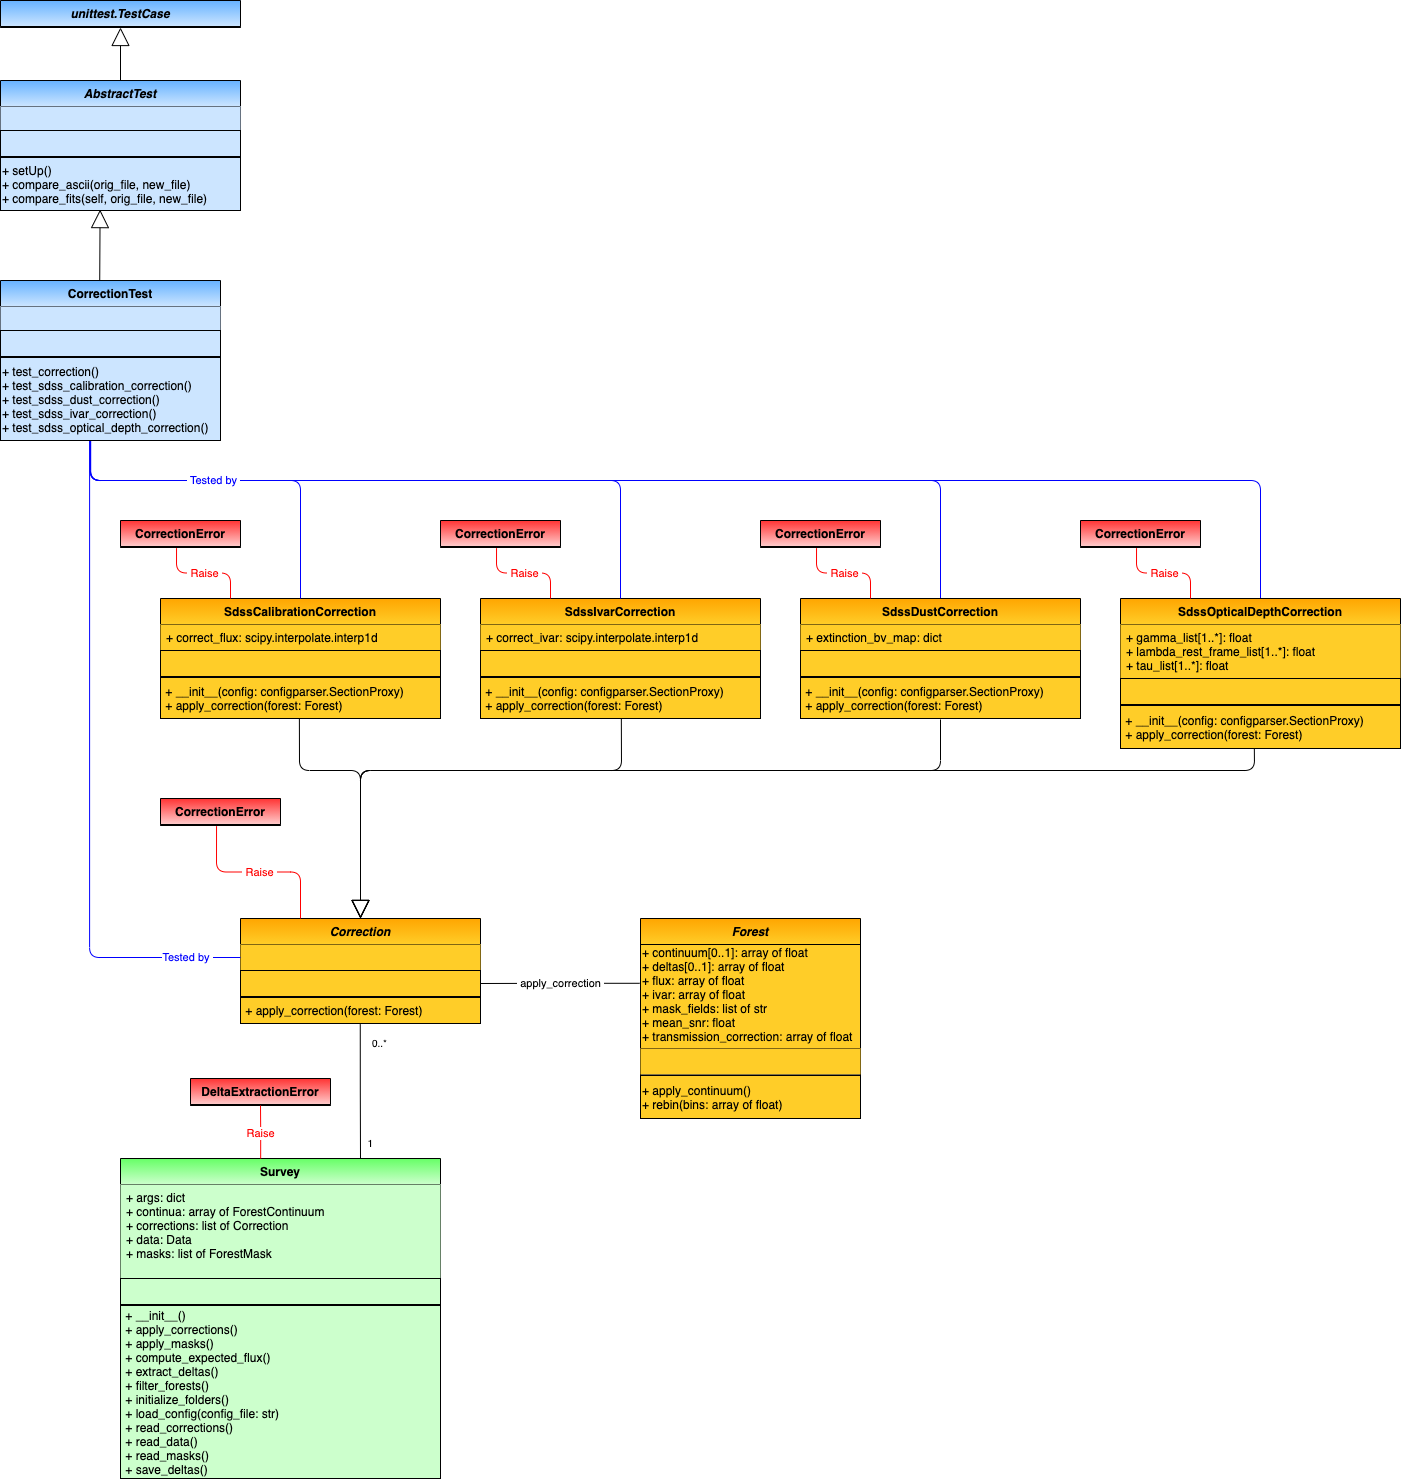

In [1]:
from IPython.display import Image
Image("../docs/data_model/data_model-Correction.png")

And the Full Data Model to put things in context

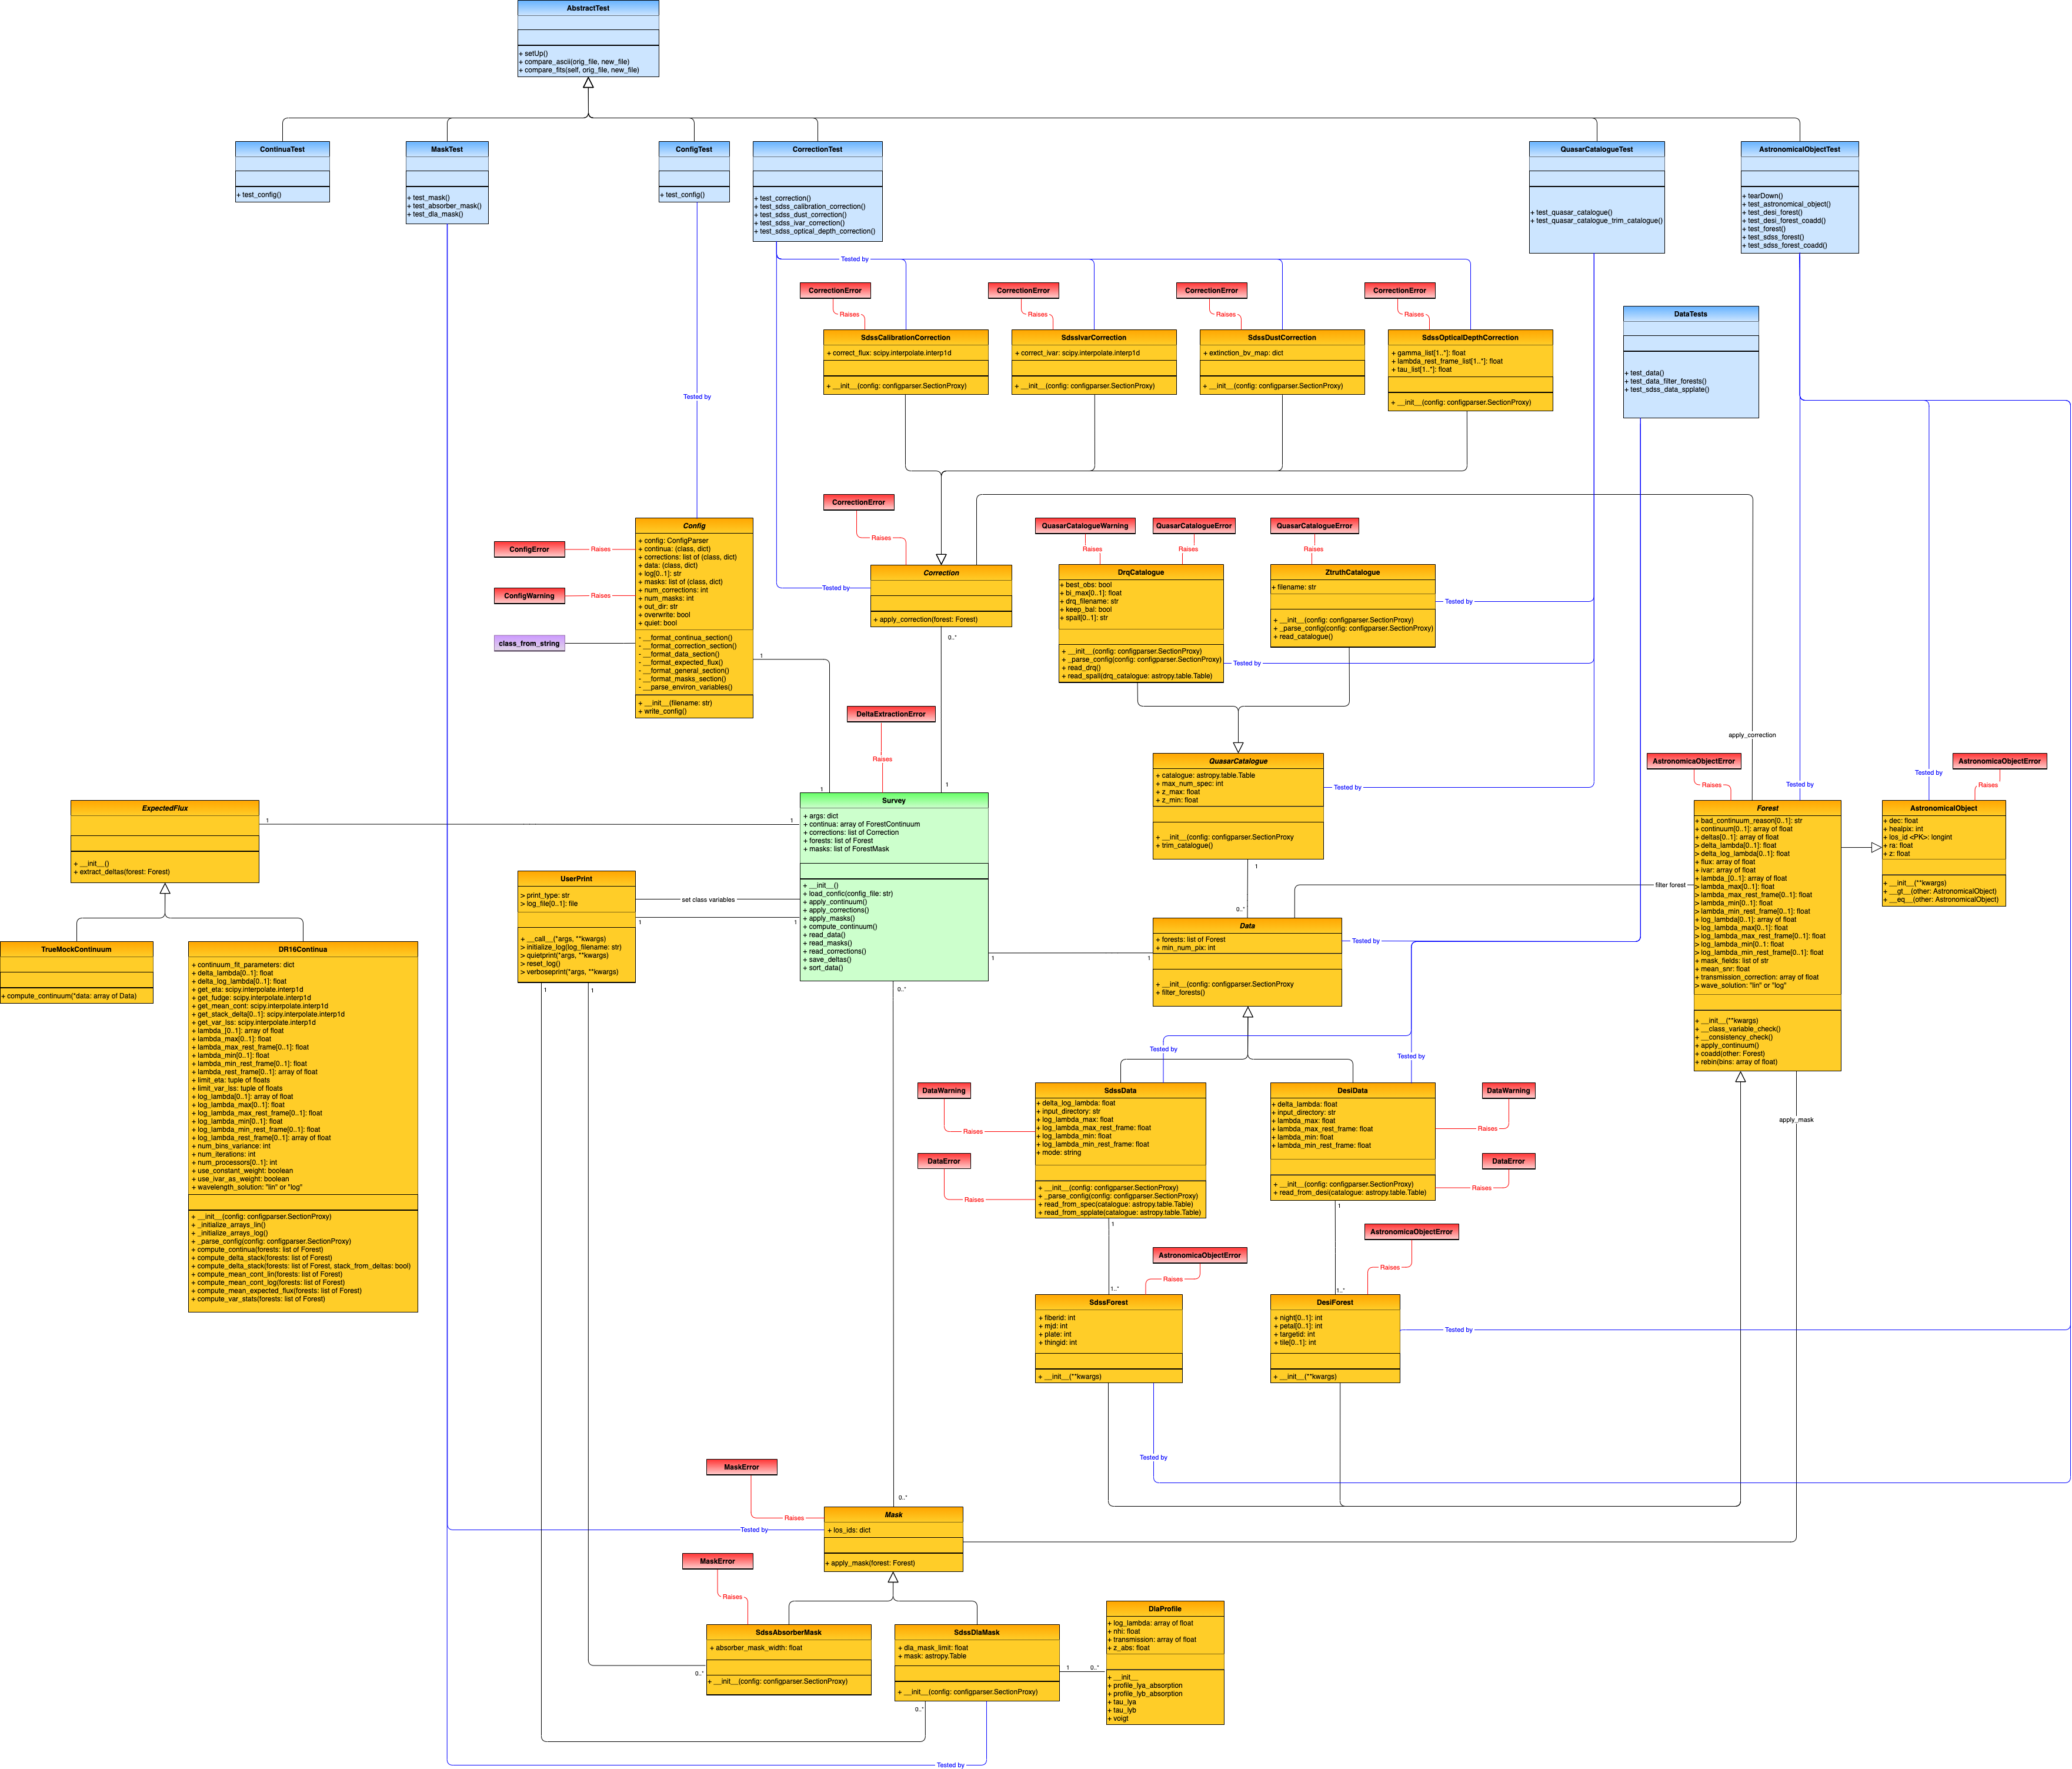

In [10]:
Image("../docs/data_model/data_model-FullDataModel.png")

# Check for similarities
Now that we know the data model, we can look for similarities. Are any of the existing corrections similar? If only minor changes are required (maybe the correction is the same, just the input format of the correction is different), it might be better to inherit from one of the already existing classes. Otherwise a new class will need to be added. The idea is that we have the least amount of repeated code.

Here are a couple of examples:

- Suppose we want to add a DesiCalibrationCorrection to the existing SdssCalibrationCorrection, and that the only thing that changes is the input file. Then we could have a parent class CalibrationCorrection (that will inherit from Correction) with the common bits of the code and two child classes DesiCalibrationCorrection and SdssCalibrationCorrection with the different bits.

- Suppose we want to add a correction that removes a slope from the flux, but does not modify the inverse variance. In this case we would create a completely new class SlopeCorrection that will inherit from Correction.

- Suppose that we want to add a correction that is exactly the same as an existing one, except that the new one operates on forets with linear wavelength solution and the existing one operates only on forests with logarithmic solutions. In this case we will just modify the existing class

# Update the data model
Once we have an idea in mind, we need to update the data model. To do so, we go to https://app.diagrams.net/ and load the data model file from `py/picca/delta_extraction/docs/data_model/data_model.drawio`. Once the file it is loaded, we add the new classes to the diagrams. We need to modify the diagram under "Corrections", but also the "FullDataModel" diagram. Do not forget to modify the test classes accordingly!

Using the export tool, we update the plots in `py/picca/delta_extraction/docs/data_model/`. 

# Create the new class
Now it's time to create the new class. Remember that we need to define the function `apply_correction`. Check the documentation of this function in `py/picca/delta_extraction/correction.py`. In general, the code will have this structure:

In [4]:
from picca.delta_extraction.correction import Correction

class MyNewCorrection(Correction):
    """This is my new correction
    
    Methods
    -------
    __init__
    apply_correction
    
    Attributes
    --------
    useful_attribute: type
    This is a useful attribute that we need to apply the correction
    """
    def __init__(self, config):
        """Initializes class instance.

        Arguments
        ---------
        config: configparser.SectionProxy
        Parsed options to initialize class
        """
        # initialize class
        pass
    
    def apply_correction(self, forest):
        """Applies the correction. Correction is applied by dividing the
        data flux by the loaded correction, and the subsequent correction
        of the inverse variance

        Arguments
        ---------
        forest: Forest
        A Forest instance to which the correction is applied

        Raises
        ------
        CorrectionError if the class is misued
        """
        # does something to forest to apply the correction
        # maybe raise some errors if, for example, a linear wavelength solution is required, but 
        # it is intead a logarithmic wavelength solution
        pass

Alternatively, if we are just slightly modifying an existing correction, we can inherit from it:

In [5]:
from picca.delta_extraction.correction import Correction

class MyOtherNewCorrection(MyNewCorrection):
    """This is my other new correction that inherits from MyNewCorrection
    
    Methods
    -------
    __init__
    apply_correction (from MyNewCorrection)
    
    Attributes
    --------
    useful_attribute: type
    This is a useful attribute that we need to apply the correction
    """
    def __init__(self, config):
        """Initializes class instance.

        Arguments
        ---------
        config: configparser.SectionProxy
        Parsed options to initialize class
        """
        # initialize class
        pass
    
    # here we do not need to define the method apply_correction since we are retrieving it from MyNewCorrection

The code should be saved in a file called `my_new_correction.py` (for `MyNewCorrection`) or `my_other_new_correction.py` (for `MyOtherNewCorrection`) which should be placed under `py/picca/delta_extraction/corrections/`. This way the configuration parser will be able to find it without us having to specify the module path

# Add tests
Once we have created our class, we need to add some tests that show that the class is working properly. This way, if we need to do some updates, we will know it still works as intended. Tests for corrections are run from `correction_tests.py`. What we need to do is to add one or more methods. Note that they need to start with 'test': 

In [7]:
def test_my_new_correction(self):
    """Test MyNewCorrection"""
    pass

def test_my_new_correction_specific_function(self):
    """Test a specific function or method used by MyNewCorrection"""
    pass

If possible, it would be nice to keep the functions in alphabetical ordering so that we can quickly find them later on

# Update configuration tutorial
Now that we are sure it works, we need to update the [corrections] section of the configuration tutorial to explain the arguments (required or not) used in the new correction. This usually includes some input filenames and/or some flags

# Add workflow diagrams
If the correction is simple, we are already finished. However, if the Correction interacts with other classes or functions, or has a number of methods, it will be useful to draw a workflow diagram. This diagram can help other people (including your future self) understand what is happening and where are things happening. This is useful not only for debugging, but also to add possible extensions to the correction.

To create a workflow diagram go to https://app.diagrams.net/ and load the workflow diagrams file from `py/picca/delta_extraction/docs/workflow/workflow.drawio`. Once the file it is loaded, we add the new workflow to the diagrams. 

Using the export tool, we update the plots in `py/picca/delta_extraction/docs/workflow/`. 

Congratulations you are done!! Now you should do a Pull Request on GitHub